In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('Dataset\doge_dataset_day_pmv.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Features and target
X = df[['market_cap', 'volume']]  # You can add more features if available
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0000
R² Score: 0.9957


## Correlation Matrix

In [9]:
print(df[['price', 'market_cap', 'volume']].corr())


               price  market_cap    volume
price       1.000000    0.999743  0.629009
market_cap  0.999743    1.000000  0.623960
volume      0.629009    0.623960  1.000000


From the correlation matrix, we can see that market cap and price is correlated. Now there are two options:
- Building a time aware model: Model depend on the past data instead of the derived current values.
- Remove market cap from the features
I will focus more one first option as it could be more realistic

# Building a time-aware model

## Using market cap lag 1

In [2]:
# Shifting features one day back to create lag features and time series analysis
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df.dropna(inplace=True)

X = df[['market_cap_lag1', 'volume_lag1']]
y = df['price']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0001
R² Score: 0.9832


## Using market cap lag 1, price lag 1

In [3]:
# Shifting features one day back to create lag features and time series analysis
df['price_lag1'] = df['price'].shift(1)
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df.dropna(inplace=True)

X = df[['price_lag1', 'market_cap_lag1', 'volume_lag1']]
y = df['price']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0001
R² Score: 0.9907


We can see that $MSE$ and $R^2$ error showing good result for both the cases in above. Another possible reason to get so accurate result is testing and splitting in random manner. Lets do it in chornological manner

## Splitting the data in chronological manner 

In [6]:
# Step 1: Sort by date (if not already sorted)
df['price_lag1'] = df['price'].shift(1)
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df.dropna(inplace=True)
df = df.sort_values('date')

# Step 2: Define train size (for example: 80% for training)
train_size = int(len(df) * 0.7)

# Step 3: Split chronologically
X = df[['price_lag1', 'market_cap_lag1', 'volume_lag1']]
y = df['price']

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Step 4: Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0003
R² Score: 0.9461


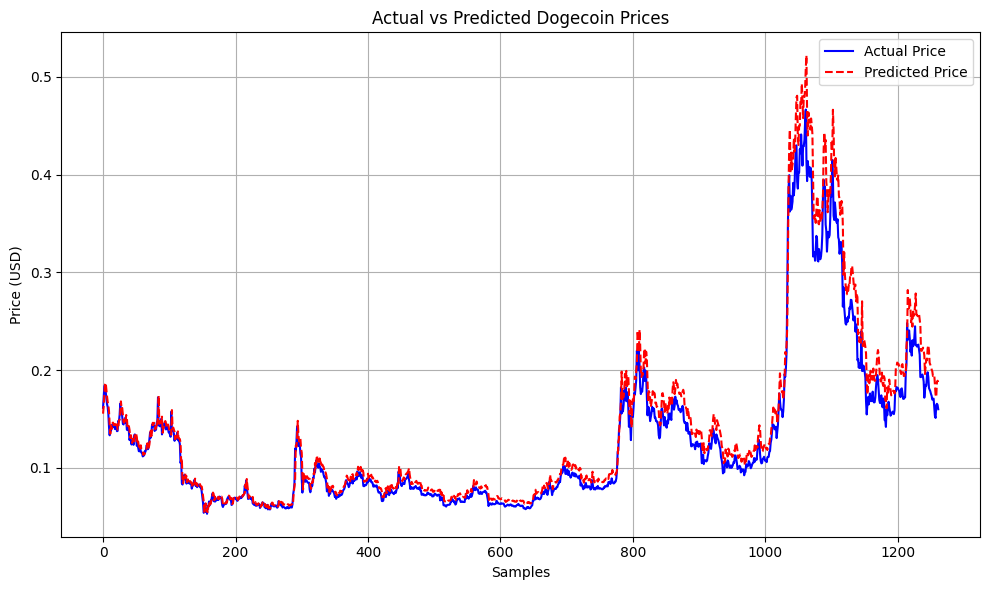

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Dogecoin Prices')
plt.xlabel('Samples')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1) Load your updated dataset (with full history up to yesterday)
df_raw = pd.read_csv('./Dataset/doge_dataset_day_pmv.csv', parse_dates=['date'])

# 2) Extract the last available day’s metrics as lag-features for tomorrow
last = df_raw.iloc[-1]
X_tomorrow = np.array([[ 
    last['price'], 
    last['market_cap'], 
    last['volume'] 
]])  # shape (1,3)

# 3) Rebuild lagged dataset and retrain (or reuse your existing `model`)
df = df_raw.copy()
df['price_lag1']      = df['price'].shift(1)
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1']     = df['volume'].shift(1)
df.dropna(inplace=True)
df = df.sort_values('date')

# Chronological split (you can skip retrain if `model` is already fit)
train_size = int(len(df) * 0.7)
X = df[['price_lag1','market_cap_lag1','volume_lag1']]
y = df['price']
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]

model = LinearRegression().fit(X_train, y_train)

# 4) Predict “today” (i.e. next-day) price
predicted_price = model.predict(X_tomorrow)[0]
print(f"📅 Based on yesterday’s data ({last['date'].date()}),")
print(f"   predicted Dogecoin price for today is: ${predicted_price:.6f}")


📅 Based on yesterday’s data (2025-06-27),
   predicted Dogecoin price for today is: $0.182815


C:\Users\miraz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
